# ライブラリ読み込み

In [3]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

# utility
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import glob
import os
import sys
from sys import stderr

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# pytorch
# conda install pytorch torchvision -c pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# 囲碁ライブラリ
from sgfmill import sgf
from sgfmill import boards

# ルートに移動
%cd /Users/keimy/git/humanized-models-for-board-games/igo
%pwd


/Users/keimy/git/humanized-models-for-board-games/igo


'/Users/keimy/git/humanized-models-for-board-games/igo'

# visualize by sgfmill

In [10]:
folders = glob.glob(f"datasets/*")
files = []
for folder in folders:
    files += glob.glob(f"{folder}/*.sgf")
    # files.extend(glob.glob(f"{folder}/*.SGF"))

len(files)

180944

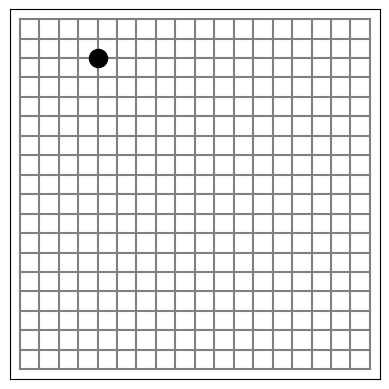

In [11]:
from src.board import visualize_board_at_move, get_board_at_move

with open(files[124], "r") as file:
    game = sgf.Sgf_game.from_string(file.read())
    visualize_board_at_move(game, 1)

In [12]:
# 19路盤
game.get_size()

19

In [35]:
# レーティングの取得
root_node = game.get_root()

# プロパティが存在するかどうかを確認してから取得
black_rank = root_node.get_raw_property_map().get("BR", [None])[0]
white_rank = root_node.get_raw_property_map().get("WR", [None])[0]

# 結果の表示（オプション）
print(f"Black player's rank: {black_rank}")
print(f"White player's rank: {white_rank}")


Black player's rank: b'6d'
White player's rank: b'7d'


In [70]:
def extract_digit_from_bytes(tmp):
    # バイト文字列を文字列に変換
    tmp_str = tmp.decode('utf-8') if tmp is not None else ''

    # 'd'が含まれる場合のみ、数字を抽出してint型に変換
    if 'd' in tmp_str:
        digits_str = ''.join([ch for ch in tmp_str if ch.isdigit()])
        return int(digits_str) if digits_str else None
    else:
        return None

# テスト
# test_bytes = [b'7d', b'6d', b'8d', b'5d', b'9d', b'4d', b'3d', b'2d', None, b'1d',
#               b'1k', b'1p', b'2k', b'4k', b'6k', b'3k', b'5k', b'9k', b'10k', b'7k',
#               b'8k', b'5p', b'11k', b'12k', b'3p', b'7p', b'13k', b'15k', b'17k', b'14k',
#               b'16k', b'18k', b'20k', b'21k', b'8p', b'9p', b'22k', b'30k', b'19k', b'27k',
#               b'23k', b'2p', b'24k', b'26k', b'25k', b'29k', b'6p', b'28k']

# for byte in test_bytes:
#     print(f"{byte}: {extract_digit_from_bytes(byte)}")



# preprocess data

In [79]:
folders = glob.glob(f"datasets/*")
files = []
for folder in folders:
    files += glob.glob(f"{folder}/*.sgf")
    # files.extend(glob.glob(f"{folder}/*.SGF"))

len(files)

179689

In [88]:
from src.board import visualize_board_at_move, get_board_at_move


arrays_at_move = []

for file in tqdm(files):
    with open(file, "r") as file:
        game = sgf.Sgf_game.from_string(file.read())
        root_node = game.get_root()

        black_rank = root_node.get_raw_property_map().get("BR", [None])[0]
        white_rank = root_node.get_raw_property_map().get("WR", [None])[0]

        black_rank = extract_digit_from_bytes(black_rank)
        white_rank = extract_digit_from_bytes(white_rank)

        if black_rank is None or white_rank is None:
            continue

        # ゲームの手数 50手以上を集める
        last = len(game.get_main_sequence()) - 1
        n_max = min(100, len(game.get_main_sequence()) - 1)
        n_min = min(50, n_max-1)
        # for i in range(n_min, n_max):
        for i in range(last):
            try:
                black_matrix, white_matrix = get_board_at_move(game, i)
                array_at_move = (i, black_rank, white_rank, np.array(black_matrix), np.array(white_matrix))
                arrays_at_move.append(array_at_move)    
            except: ValueError


100%|██████████| 179689/179689 [8:50:47<00:00,  5.64it/s]  


In [89]:
# ゲーム番号、盤面rootなどは割愛

dtype = [('move', int), ('black_rank', int), ('white_rank', int), ('black_matrix', float, (19, 19)), ('white_matrix', float, (19, 19))]
arrays_at_move = np.array(arrays_at_move, dtype=dtype)

# moveを保存
# np.save('./preprocess/arrays_at_move.npy', arrays_at_move)
np.savez_compressed('./preprocess/arrays_at_move.npz', arrays_at_move)


# Loading Data

In [85]:
# numpyファイルを呼び出す
arrays_at_move2 = np.load('./preprocess/arrays_at_move.npy', allow_pickle=True)


# Pyaq
https://github.com/ymgaq/Pyaq/tree/master